# YOLO11 Relax 推理

In [1]:
import torch
torch.cuda.empty_cache()


0: 416x640 1 car, 95.4ms
Speed: 5.8ms preprocess, 95.4ms inference, 264.6ms postprocess per image at shape (1, 3, 416, 640)


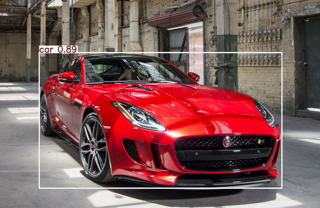

In [2]:
from PIL import Image
import numpy as np
from ultralytics import YOLO

input_path = "images/vehicle-jaguar-f-type-car-red-cars-wallpaper.jpg"
im = Image.open(input_path) #.resize((384, 640))
yolo = YOLO("yolo11n.pt")
results = yolo(np.array(im), conf=0.25)
Image.fromarray(results[0].plot()).resize((320, 208))

预处理：

数据内存的连续性：True
数据内存的连续性(transpose)：False
数据内存的连续性：True


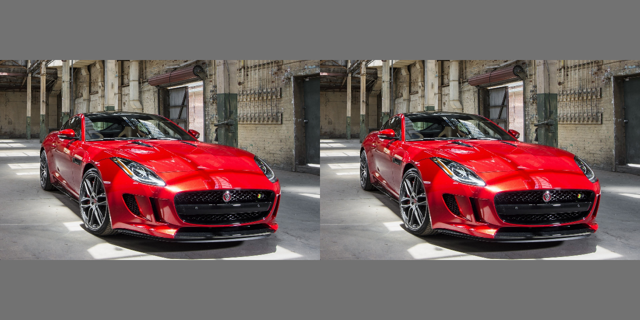

In [3]:
from PIL import Image
import numpy as np
import torch
from ultralytics.data.augment import LetterBox

imgsz = 640, 640
strides = yolo.model.stride
mean = (0,)
std = (255,)

letterbox = LetterBox(new_shape=imgsz, auto=False, scaleFill=False, scaleup=True, stride=32)
origin_image = np.asanyarray(Image.open(input_path))
letterbox_image = letterbox(image=origin_image)
xs = np.stack([letterbox_image - mean])
print(f"数据内存的连续性：{xs.flags["C_CONTIGUOUS"]}")
xs = xs.transpose((0, 3, 1, 2))  # BHWC to BCHW, (n, 3, h, w)
print(f"数据内存的连续性(transpose)：{xs.flags["C_CONTIGUOUS"]}")
xs = np.ascontiguousarray(xs)  # contiguous
print(f"数据内存的连续性：{xs.flags["C_CONTIGUOUS"]}")
xs = (xs / std).astype("float32") # 归一化值域范围为 0.0 - 1.0
Image.fromarray(
    np.concatenate([letterbox_image, (xs[0]*std).astype("uint8").transpose((1, 2, 0))], axis=1)
).resize((640, 320,))

后处理：

In [4]:
from ultralytics.utils import ops
from ultralytics.engine.results import Results

def postprocess(preds, img, orig_imgs, names, input_path, conf_thres=0.25, iou_thres=0.45,):
    """Post-processes predictions and returns a list of Results objects."""
    preds = ops.non_max_suppression(
        preds,
        conf_thres=conf_thres,
        iou_thres=iou_thres,
        # agnostic=self.args.agnostic_nms,
        # max_det=self.args.max_det,
        # classes=80,
    )

    results = []
    for i, pred in enumerate(preds):
        orig_img = orig_imgs[i]
        pred[:, :4] = ops.scale_boxes(img.shape[2:], pred[:, :4], orig_img.shape)
        img_path = input_path
        results.append(Results(orig_img, path=img_path, names=names, boxes=pred))
    return results

## ONNX 推理

In [5]:
import onnxruntime
import onnx
onnx_model = onnx.load('yolo11n.onnx')
# 通过 ONNX 运行模型以获取预期结果
ort_session = onnxruntime.InferenceSession(
    onnx_model.SerializeToString(), providers=["CPUExecutionProvider"]
)
inputs = {"images": xs}
ort_output = ort_session.run([], inputs)

## 测试 YOLO ONNX Relax 前端

In [6]:

import tvm
from tvm import relax
from tvm.relax.frontend.onnx import from_onnx

In [7]:
tvm_model = from_onnx(onnx_model, keep_params_in_input=False)

# 将算子转换为推理模式
tvm_model = relax.transform.DecomposeOpsForInference()(tvm_model)
tvm_model.show()
# 将任何 Relax 算子合法化为 TensorIR
tvm_model = relax.transform.LegalizeOps()(tvm_model)

# 将模型与参数分离
tvm_model, params = relax.frontend.detach_params(tvm_model)
# 将 Relax 图编译为虚拟机（VM）然后运行
with tvm.transform.PassContext(opt_level=3):
    ex = relax.build(tvm_model, target="llvm")
    vm = relax.VirtualMachine(ex, tvm.cpu())

准备输入：

In [8]:
input_list = [
    inputs[key.name_hint] for key in tvm_model["main"].params if key.name_hint in inputs
]
if params:
    input_list += params["main"]

运行模型并检查输出：

In [9]:
vm.set_input("main", *input_list)
vm.invoke_stateful("main")
tvm_output = vm.get_outputs("main")
# 如果只有一个输出，则将其包装为列表
if len(ort_output) == 1:
    # 对于 TVM 不检查输出数量  
    # 对于序列输出，TVM 的输出是元组（Tuple），  
    # 而 ONNX 的输出数量是一个，即列表形式。
    tvm_output = [tvm_output]

In [10]:
def _check_output(tvm_out: list, ort_out: list, rtol: float = 1e-7, atol: float = 1e-5,):
    if isinstance(tvm_out, tuple) and isinstance(ort_out, (tvm.runtime.ShapeTuple, list)):
        assert len(tvm_out) == len(ort_out), "Unequal number of outputs"
        for tvm_out_i, ort_out_i in zip(tvm_out, ort_out):
            _check_output(tvm_out_i, ort_out_i)
    elif isinstance(tvm_out, tvm.nd.NDArray) and isinstance(ort_out, np.ndarray):
        np.testing.assert_allclose(tvm_out.numpy(), ort_out, rtol=rtol, atol=atol)
    elif isinstance(tvm_out, tvm.runtime.ShapeTuple) and isinstance(ort_out, np.ndarray):
        shape_out = tvm.nd.array([int(i) for i in tvm_out])
        np.testing.assert_allclose(shape_out.numpy(), ort_out, rtol=rtol, atol=atol)
    elif isinstance(tvm_out, (int, float, bool)) and isinstance(ort_out, np.ndarray):
        np.testing.assert_allclose(np.array(tvm_out), ort_out, rtol=rtol, atol=atol)
    else:
        raise ValueError(f"Unsupported types: {type(tvm_out)}, {type(ort_out)}")

In [11]:
# Check that number of outputs match.
assert len(tvm_output) == len(ort_output), "Unequal number of outputs"
for tvm_out, ort_out in zip(tvm_output, ort_output):
    # TODO Allow configurable tolerance.
    if ort_out is not None:
        _check_output(tvm_out, ort_out, rtol=1e-4, atol=1e-5)

## 测试 YOLO TorchScript Relax 前端

In [12]:
import torch
from torch import fx
import tvm
from tvm.driver.tvmc.frontends import load_model
from tvm.relax.frontend.torch import from_fx
from tvm.contrib.msc.core.frontend import translate
# from tvm.contrib.msc.framework.torch.frontend import translate
from tvm.contrib.msc.framework.tvm import codegen as tvm_codegen

model = load_model("yolo11n.torchscript", "pytorch", shape_dict={"x": (1, 3, 640, 640)})
opt_config = {"opt_level": 3}
graph, weights = translate.from_relay(model.mod, model.params, opt_config=opt_config)
codegen_config = {"explicit_name": False, "from_relay": True}
rt_mod = tvm_codegen.to_relax(graph, weights, codegen_config)

In [13]:
rt_mod.show()

In [14]:
# 将算子转换为推理模式
tvm_model = relax.transform.DecomposeOpsForInference()(rt_mod)
# 将任何 Relax 算子合法化为 TensorIR
tvm_model = relax.transform.LegalizeOps()(tvm_model)

# 将模型与参数分离
tvm_model, params = relax.frontend.detach_params(tvm_model)
# 将 Relax 图编译为虚拟机（VM）然后运行
with tvm.transform.PassContext(opt_level=3):
    ex = relax.build(tvm_model, target="llvm")
    vm = relax.VirtualMachine(ex, tvm.cpu())

vm.set_input("main", *input_list)
vm.invoke_stateful("main")
tvm_output = vm.get_outputs("main").numpy()

校验结果：

In [15]:
torch_model = torch.jit.load("yolo11n.torchscript")
with torch.no_grad():
    pred = torch_model(torch.from_numpy(xs)).numpy()
np.testing.assert_allclose(tvm_output, pred, rtol=1e-4, atol=1e-5)